In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the MNIST dataset
])

# Download training data
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Download test data
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [11]:
def train_model():
    # Define transformations for the input data
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize the MNIST dataset
    ])

    # Load the datasets
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

    # Initialize the network and optimizer
    model = LeNet()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Train the network
    model.train()
    for epoch in range(20):  # Loop over the dataset multiple times (5 epochs for brevity)
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Save the trained model
    torch.save(model.state_dict(), 'lenet_mnist_model.pth')
    print('Finished Training and saved the model as lenet_mnist_model.pth')

train_model()


Epoch 1, Loss: 0.10090438276529312
Epoch 2, Loss: 0.09125611931085587
Epoch 3, Loss: 0.0011607807828113437
Epoch 4, Loss: 0.0008392716408707201
Epoch 5, Loss: 0.005084543488919735
Epoch 6, Loss: 0.00025971693685278296
Epoch 7, Loss: 0.017525911331176758
Epoch 8, Loss: 0.004148777574300766
Epoch 9, Loss: 0.032408542931079865
Epoch 10, Loss: 0.0023209520149976015
Epoch 11, Loss: 0.0008168990025296807
Epoch 12, Loss: 0.0002334930468350649
Epoch 13, Loss: 0.001467919908463955
Epoch 14, Loss: 0.00038959740777499974
Epoch 15, Loss: 3.732561481228913e-06
Epoch 16, Loss: 0.001443771063350141
Epoch 17, Loss: 2.3993208742467687e-05
Epoch 18, Loss: 2.682158765310305e-06
Epoch 19, Loss: 1.605621218914166e-05
Epoch 20, Loss: 0.0004048168775625527
Finished Training and saved the model as lenet_mnist_model.pth


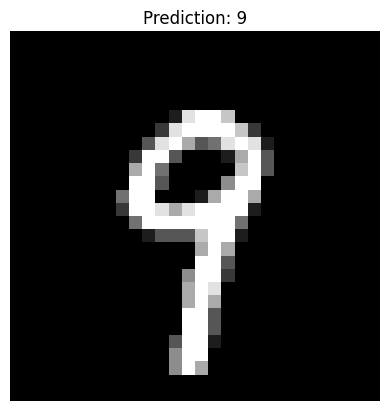

In [12]:
def load_pretrained_model_and_predict():
    # Load the pretrained model
    model = LeNet()
    model.load_state_dict(torch.load('lenet_mnist_model.pth'))
    model.eval()

    # Load one example from the MNIST test set
    test_set = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
    test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
    data, target = next(iter(test_loader))

    # Predict
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

    # Show the input image and the model's prediction
    plt.imshow(data[0][0].numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {pred.item()}')
    plt.axis('off')
    plt.show()

load_pretrained_model_and_predict()



Test set: Average loss: 0.0274, Accuracy: 9942/10000 (99%)



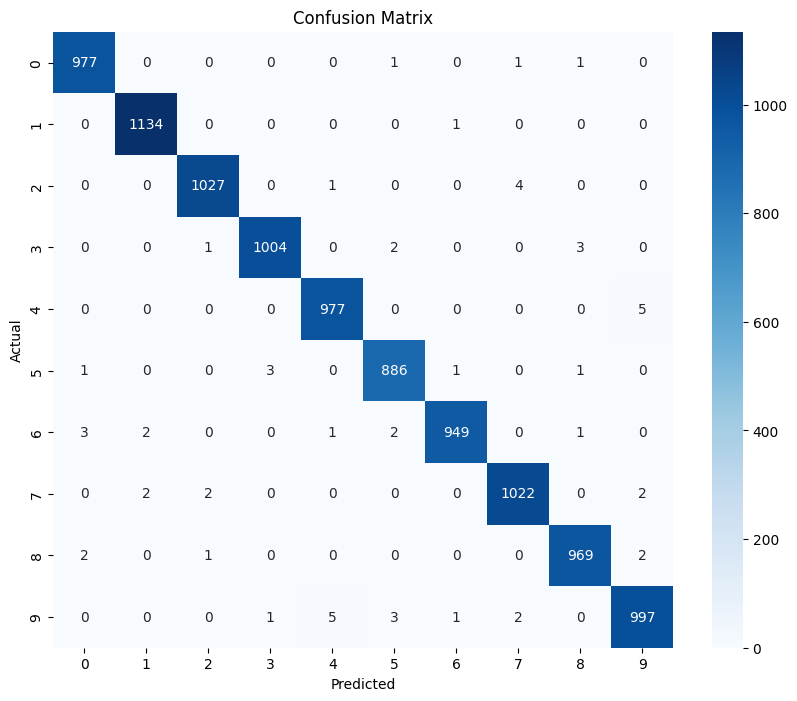

In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_model(model, device):
    # Transformation for evaluating model
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load MNIST test data
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

    model.eval()  # Set the model to evaluation mode
    model.to(device)

    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Operations inside don't track history
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).tolist())
            all_targets.extend(target.view(-1).tolist())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet()  # Assuming LeNet is already defined
model.load_state_dict(torch.load('lenet_mnist_model.pth'))
evaluate_model(model, device)


In [22]:
train_set[0][0].shape

torch.Size([1, 28, 28])

tensor([[-19.0063,   3.8866, -14.5780,  26.7414, -15.9117,  37.7552, -18.0348,
          -8.7614,   2.3636,   4.1386]], grad_fn=<AddmmBackward0>)

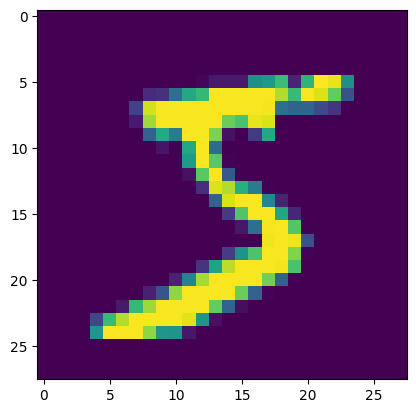

In [25]:
import matplotlib
import matplotlib.pyplot
matplotlib.pyplot.imshow(train_set[0][0].squeeze())

model(train_set[0][0])

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb, rgb2gray
from skimage import io
from skimage.color import rgb2gray
from sklearn.linear_model import LogisticRegression  # Example classifier

class ImageSuperpixelWrapper:
    def __init__(self, image, n_segments=100, compactness=10.0, sigma=1.0, classifier=None, explanation_index=0):
        #self.image = io.imread(image_path)
        if type(image) == 'str':
            self.image = io.imread(image)
            if self.image.ndim == 3:
                self.image = rgb2gray(self.image)  # Convert to greyscale if not already
        else:
            self.image = image

        self.n_segments = n_segments
        self.compactness = compactness
        self.sigma = sigma
        self.segments = slic(self.image, n_segments=n_segments, compactness=self.compactness, sigma=self.sigma, channel_axis=None)
        self.n_segments = np.max(self.segments)
        self.vector = np.ones(self.n_segments)
        self.classifier = classifier
        self.explanation_index = explanation_index

    def show_segments(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
        ax.imshow(label2rgb(self.segments, self.image, kind='avg'), interpolation='nearest')
        ax.set_title('SLIC Segmentation')
        ax.axis('off')
        plt.show()

    def encode_superpixels(self):
        # Binary vector for superpixels' presence
        self.vector = np.ones(self.n_segments)

    def remove_superpixel(self, sp_id):
        # Set to 0 in binary vector
        modified_img = self.image.copy()
        modified_img[self.segments == sp_id] = [128, 128, 128]  # Grey out the superpixel
        modified_img.vector[sp_id] = 0
    
        return modified_img

    def binary_encode(self, binary_code):
        modified_img = self.image.copy()
        remove_idx = np.where(np.array(binary_code) == 0)
        index = np.isin(self.segments, remove_idx)
        modified_img[index] = 0
        
        return modified_img


    def map_original_to_superpixel(self):
        # Maps each pixel to its superpixel ID
        return self.segments

    def map_superpixel_to_original(self, sp_id):
        # Find all pixels belonging to a given superpixel ID
        return np.argwhere(self.segments == sp_id)
    
    def __call__(self, binary_encode):
        modified_image = self.binary_encode(binary_encode)
        probabilities = torch.nn.functional.softmax(self.classifier(torch.from_numpy(modified_image).unsqueeze(0)), dim=1).squeeze(0)

        return probabilities.detach().numpy().squeeze()[self.explanation_index]


# Example usage:
# Load an image and a trained classifier (dummy example here)
wrapper = ImageSuperpixelWrapper(train_set[0][0].squeeze().numpy(), classifier=model)

# Encode superpixels
wrapper.encode_superpixels()



In [113]:
import shap

In [114]:
img = train_set[0][0]
probabilities = torch.nn.functional.softmax(model(img), dim=1).squeeze(0)
predicted_class = probabilities.argmax(dim=0).numpy()
img = img.squeeze().numpy()

wrapper = ImageSuperpixelWrapper(img, classifier=model, explanation_index=predicted_class)

binary_encode = wrapper.vector
x_train = np.zeros((1, binary_encode.shape[0]))



In [117]:
wrapper(x_train)

0.10416316

In [118]:
explainer = shap.KernelExplainer(wrapper, x_train)

IndexError: tuple index out of range

In [91]:
print(predicted_class.numpy())

5
